In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import emoji

from googletrans import Translator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from transformers import pipeline, AutoTokenizer
from collections import Counter


%matplotlib inline
sns.set_style("whitegrid")

#set warning 
import warnings
warnings.filterwarnings('ignore')


pd.pandas.set_option('display.max_columns', None)

In [20]:
filename = "BYD-M6.csv"
df = pd.read_csv(filename, encoding = 'latin-1')
df

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1956653409953886320,Sat Aug 16 09:45:00 +0000 2025,0,Sepanjang 2025 20.795 unit mobil CBU dari BYD ...,1956653409953886320,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/195665340995388...,350668803,NaN
1,1956214303339487523,Fri Aug 15 11:17:06 +0000 2025,0,@tanyarlfes Motor impian Honda super cub C100 ...,1956314202072650209,NaN,tanyarlfes,in,NaN,0,0,0,https://x.com/undefined/status/195631420207265...,1193997693904809984,NaN
2,1956020121518137693,Thu Aug 14 15:48:32 +0000 2025,0,tiap pagi n sore lagi melintasi jalanan sudirm...,1956020121518137693,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/195602012151813...,568999509,NaN
3,1952613025418252500,Tue Aug 05 06:09:57 +0000 2025,0,Di tengah mahalnya harga mobil baru dan melonj...,1952613025418252500,https://pbs.twimg.com/media/GxkTGvTbQAER0u8.jpg,NaN,in,NaN,0,0,0,https://x.com/undefined/status/195261302541825...,1912027937676853249,NaN
4,1951489959233573009,Sat Aug 02 03:47:17 +0000 2025,0,BYD M6: Kombinasi Desain Elegan dan Kekuatan M...,1951489959233573009,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/195148995923357...,227969034,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,25885078568,Wed Sep 29 13:59:53 +0000 2010,0,BYD Automobile Cina Pasarkan Mobil Keluarga M6...,25885078568,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/25885078568,149796787,NaN
340,25885078530,Wed Sep 29 13:59:53 +0000 2010,0,BYD Automobile Cina Pasarkan Mobil Keluarga M6...,25885078530,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/25885078530,170540140,NaN
341,25885078003,Wed Sep 29 13:59:52 +0000 2010,0,BYD Automobile Cina Pasarkan Mobil Keluarga M6...,25885078003,NaN,NaN,in,NaN,0,0,1,https://x.com/undefined/status/25885078003,18129942,NaN
342,25885077287,Wed Sep 29 13:59:52 +0000 2010,0,BYD Automobile Cina Pasarkan Mobil Keluarga M6...,25885077287,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/25885077287,20963426,NaN


# DELETE COLOMN

In [21]:
df = df.drop(columns=[
    'conversation_id_str',
    'created_at',
    'favorite_count',
    'id_str',
    'image_url',
    'in_reply_to_screen_name',
    'lang',
    'location',
    'quote_count',
    'reply_count',
    'retweet_count',
    'tweet_url',
    'user_id_str',
    'username'
])

df.rename(columns={"full_text" : "Comment"}, inplace=True)

df


,Comment
0,Sepanjang 2025 20.795 unit mobil CBU dari BYD ...
1,@tanyarlfes Motor impian Honda super cub C100 ...
2,tiap pagi n sore lagi melintasi jalanan sudirm...
3,Di tengah mahalnya harga mobil baru dan melonj...
4,BYD M6: Kombinasi Desain Elegan dan Kekuatan M...
...,...
339,BYD Automobile Cina Pasarkan Mobil Keluarga M6...
340,BYD Automobile Cina Pasarkan Mobil Keluarga M6...
341,BYD Automobile Cina Pasarkan Mobil Keluarga M6...
342,BYD Automobile Cina Pasarkan Mobil Keluarga M6...


# STOPWORD, STEMMING, AND REMOVING EMOJIS

In [22]:
# Indonesian stopwords
indonesian_stopwords = set(nltk.corpus.stopwords.words('indonesian'))

# You can add more custom stopwords if needed (bisa ditambah)
custom_stopwords = set(['di', 'yang', 'dan', 'ini', 'dengan', 'dari', 'untuk', 
 'pada', 'jadi', 'bisa', 'ada', 'buat', 'lebih', 'sama', 'juga', 'lagi', 'ya']
)
all_stopwords = indonesian_stopwords.union(custom_stopwords)


# Initialize the Indonesian stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Stemming
prefixes = ("me", "mem", "men", "meng", "meny",
             "ber", "ter", "se", "ke", "pe", "di")

# Function to remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)


# Function to remove emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Function to remove non-alphabetic characters, URLs, and emojis, tokenize, remove stopwords, and stem (kata dibawah 3 diatas 20)
def preprocess_text(text):
    text = str(text)
    text = remove_urls(text)  # Remove URLs
    text = remove_emojis(text)  # Remove emojis
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    tokens = word_tokenize(text)  # Tokenize the text
    filtered_tokens = [stemmer.stem(token) for token in tokens if 3 <= len(token) <= 20 and token.lower() not in all_stopwords]  # Remove stopwords and apply stemming
    return ' '.join(filtered_tokens)


# Apply preprocessing to the text column
df['Cleaned_Comment'] = df['Comment'].apply(preprocess_text)

# Display the first few rows of the dataframe with cleaned text
df_display = df[['Comment', 'Cleaned_Comment']]
df_display.head()

,Comment,Cleaned_Comment
0,Sepanjang 2025 20.795 unit mobil CBU dari BYD ...,unit mobil cbu byd masuk indonesia byd sealion...
1,@tanyarlfes Motor impian Honda super cub C100 ...,tanyarlfes motor impi honda super cub mobil im...
2,tiap pagi n sore lagi melintasi jalanan sudirm...,pagi sore lintas jalan sudirman senayan trs kt...
3,Di tengah mahalnya harga mobil baru dan melonj...,mahal harga mobil lonjak minat kendara listrik...
4,BYD M6: Kombinasi Desain Elegan dan Kekuatan M...,byd kombinasi desain elegan kuat mobil listrik...


# Load model, tokenizer IndoBERT, and mapping label 

In [23]:
# Model IndoBERT Sentiment
model_name = 'mdhugol/indonesia-bert-sentiment-classification'

# Gunakan PyTorch backend
sentiment_pipeline = pipeline('sentiment-analysis', model=model_name, tokenizer=model_name, framework='pt')
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Truncate teks (maks 512 token)
def truncate_text(text, max_length=512):
    inputs = tokenizer(text, max_length=max_length, truncation=True, return_tensors='pt')
    return tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True)

# Preprocessing dan analisis sentimen
df['Cleaned_Comment'] = df['Comment'].apply(preprocess_text)
df['Sentiment'] = df['Cleaned_Comment'].apply(lambda x: sentiment_pipeline(truncate_text(x))[0]['label'])

# Mapping label sesuai hasil konfigurasi model IndoBERT
label_mapping = {
    'LABEL_0': 'negative',
'LABEL_1': 'neutral',
    'LABEL_2': 'positive'
}

# Buat kolom baru dengan label teks
df['Sentiment_Label'] = df['Sentiment'].map(label_mapping)

# Tampilkan hasil
df_display = df[['Comment', 'Cleaned_Comment', 'Sentiment_Label']]
df_display.head()


Device set to use cpu


,Comment,Cleaned_Comment,Sentiment_Label
0,Sepanjang 2025 20.795 unit mobil CBU dari BYD ...,unit mobil cbu byd masuk indonesia byd sealion...,neutral
1,@tanyarlfes Motor impian Honda super cub C100 ...,tanyarlfes motor impi honda super cub mobil im...,neutral
2,tiap pagi n sore lagi melintasi jalanan sudirm...,pagi sore lintas jalan sudirman senayan trs kt...,negative
3,Di tengah mahalnya harga mobil baru dan melonj...,mahal harga mobil lonjak minat kendara listrik...,positive
4,BYD M6: Kombinasi Desain Elegan dan Kekuatan M...,byd kombinasi desain elegan kuat mobil listrik...,negative


# DISPLAY THE CHART

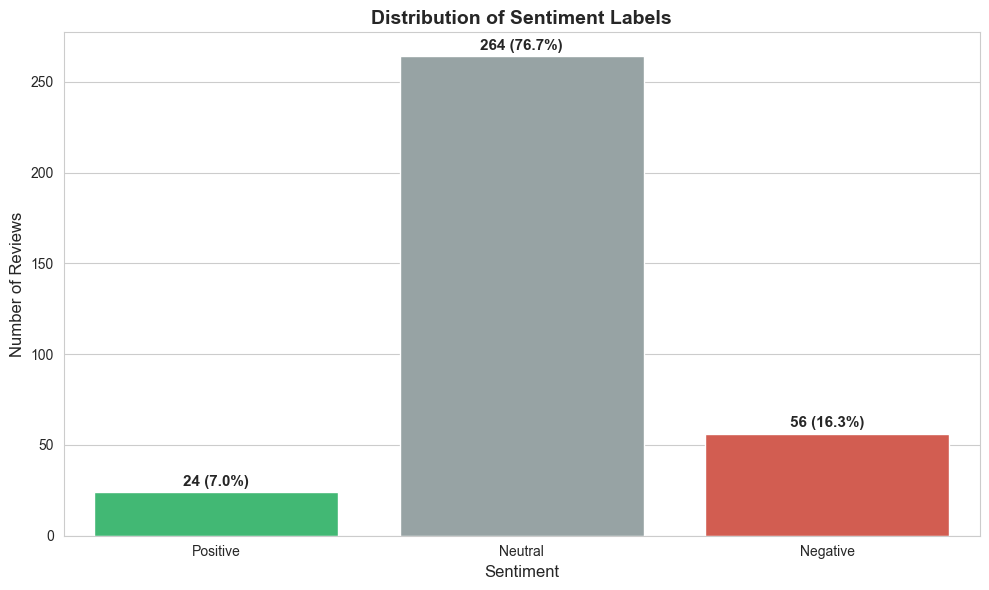

In [24]:
# Mapping label ke teks
label_mapping = {
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive'
}

# Ubah label di kolom Sentiment
df['Sentiment_Label'] = df['Sentiment'].map(label_mapping)

# Hitung jumlah masing-masing sentimen
sentiment_counts = df['Sentiment_Label'].value_counts()

# Urutan label (pastikan sama dengan urutan warna)
order = ['Positive', 'Neutral', 'Negative']

# Warna sesuai urutan label di atas
colors = ['#2ecc71', '#95a5a6', '#e74c3c']  # hijau, abu-abu, merah

# Plot distribusi
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x=sentiment_counts.loc[order].index,
    y=sentiment_counts.loc[order].values,
    palette=colors
)

# Tambahkan teks di atas setiap batang
total = sentiment_counts.sum()
for i, value in enumerate(sentiment_counts.loc[order].values):
    percent = (value / total) * 100
    ax.text(i, value + 2, f'{value} ({percent:.1f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Atur tampilan
plt.title('Distribution of Sentiment Labels', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# display each sentiment

In [25]:
# Display basic statistics of sentiment labels
print("Basic Statistics of Sentiment Labels:")
print(df['Sentiment'].describe())

# Count of each sentiment
print("\nCount of each sentiment:")
print(sentiment_counts)

# Word Frequency Analysis
all_words = ' '.join(df['Cleaned_Comment']).split()
word_freq = Counter(all_words)

# Display the most common words
print("\nMost common words:")
print(word_freq.most_common(20))

# Text Length Analysis
df['text_length'] = df['Cleaned_Comment'].apply(len)
print("\nText length statistics:")
print(df['text_length'].describe())

# Display examples of each sentiment
print("\nExamples of Positive Reviews:")
print(df[df['Sentiment'] == 'Positive'][['Cleaned_Comment']].head())

print("\nExamples of Neutral Reviews:")
print(df[df['Sentiment'] == 'Neutral'][['Cleaned_Comment']].head())


print("\nExamples of Negative Reviews:")
print(df[df['Sentiment'].str.contains('Negative')][['Cleaned_Comment']].head())

Basic Statistics of Sentiment Labels:
count         344
unique          3
top       LABEL_1
freq          264
Name: Sentiment, dtype: object

Count of each sentiment:
Sentiment_Label
Neutral     264
Negative     56
Positive     24
Name: count, dtype: int64

Most common words:
[('byd', 368), ('mobil', 284), ('listrik', 190), ('indonesia', 79), ('mpv', 74), ('harga', 48), ('laris', 44), ('giias', 44), ('keluarga', 35), ('luncur', 35), ('juta', 32), ('jual', 31), ('pasar', 28), ('innova', 24), ('unit', 23), ('bmw', 21), ('semarang', 20), ('wuling', 19), ('cina', 16), ('zenix', 16)]

Text length statistics:
count    344.000000
mean      69.031977
std       42.562341
min        0.000000
25%       41.750000
50%       56.000000
75%       81.250000
max      235.000000
Name: text_length, dtype: float64

Examples of Positive Reviews:
Empty DataFrame
Columns: [Cleaned_Comment]
Index: []

Examples of Neutral Reviews:
Empty DataFrame
Columns: [Cleaned_Comment]
Index: []

Examples of Negative Review